<a href="https://colab.research.google.com/github/moon2su/ML-programming/blob/main/HAR_Resnet_CBAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/Colab Notebooks/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/Colab Notebooks/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

from sklearn.model_selection import train_test_split

X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)

from sklearn.preprocessing import StandardScaler

# ---------- 데이터 스케일링 함수 ----------
def scale_3d_timeseries(X_train, X_val, X_test=None):
    """
    3D 시계열 (N, T, F) 형태의 데이터를 feature-wise로 표준화
    """
    N, T, F = X_train.shape
    scaler = StandardScaler()

    scaler.fit(X_train.reshape(-1, F))

    def transform_3d(X):
        if X is None:
            return None
        N_, T_, F_ = X.shape
        X2 = X.reshape(-1, F_)
        X2 = scaler.transform(X2)
        return X2.reshape(N_, T_, F_)

    X_train_scaled = transform_3d(X_train)
    X_val_scaled = transform_3d(X_val)
    X_test_scaled = transform_3d(X_test)

    return X_train_scaled, X_val_scaled, X_test_scaled, scaler

# ---------- 실행 ----------
X_train_scaled, X_val_scaled, X_test_scaled, scaler = scale_3d_timeseries(X_train, X_val, testX)

# 스케일링 후 shape 확인
print("Scaled shapes:")
print("X_train_scaled:", X_train_scaled.shape)
print("X_val_scaled:", X_val_scaled.shape)
print("X_test_scaled:", X_test_scaled.shape)
print("-------------------")

X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape

/tmp/ipython-input-2086117023.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-2086117023.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-2086117023.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-2086117023.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)
Scaled shapes:
X_train_scaled: (5881, 128, 9)
X_val_scaled: (1471, 128, 9)
X_test_scaled: (2947, 128, 9)
-------------------


((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881, 1), (1471, 1))

In [4]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import (
    GlobalAveragePooling1D, GlobalMaxPooling1D,
    Dense, Reshape, Add, Multiply, Conv1D, Concatenate, Activation, Lambda
)

def cbam_block_1d(x, reduction_ratio=8, kernel_size=7, name=None):
    """
    x: (batch, time, channels) 형태의 1D feature map
    CBAM = Channel Attention + Spatial Attention
    """
    if name is None:
        name = "cbam"

    ch = x.shape[-1]

    # -----------------------
    # 1) Channel Attention
    # -----------------------
    avg_pool = GlobalAveragePooling1D(name=name+"_ch_avgpool")(x)
    max_pool = GlobalMaxPooling1D(name=name+"_ch_maxpool")(x)

    shared_mlp = tf.keras.Sequential([
        Dense(ch // reduction_ratio, activation='relu', use_bias=True),
        Dense(ch, use_bias=True)
    ], name=name+"_shared_mlp")

    avg_fc = shared_mlp(avg_pool)
    max_fc = shared_mlp(max_pool)

    ch_attn = Add(name=name+"_ch_add")([avg_fc, max_fc])
    ch_attn = Activation('sigmoid', name=name+"_ch_sigmoid")(ch_attn)
    ch_attn = Reshape((1, ch), name=name+"_ch_reshape")(ch_attn)

    x_ch = Multiply(name=name+"_ch_mul")([x, ch_attn])

    # -----------------------
    # 2) Spatial Attention
    # -----------------------
    # ❗ 여기서 tf.reduce_mean / tf.reduce_max 를 Lambda 레이어로 감쌈
    avg_pool_spatial = Lambda(
        lambda t: tf.reduce_mean(t, axis=-1, keepdims=True),
        name=name+"_sp_avg"
    )(x_ch)

    max_pool_spatial = Lambda(
        lambda t: tf.reduce_max(t, axis=-1, keepdims=True),
        name=name+"_sp_max"
    )(x_ch)

    spatial = Concatenate(axis=-1, name=name+"_sp_concat")(
        [avg_pool_spatial, max_pool_spatial]
    )  # (batch, time, 2)

    spatial = Conv1D(
        filters=1,
        kernel_size=kernel_size,
        padding='same',
        use_bias=False,
        name=name+"_sp_conv"
    )(spatial)

    spatial_attn = Activation('sigmoid', name=name+"_sp_sigmoid")(spatial)

    x_out = Multiply(name=name+"_sp_mul")([x_ch, spatial_attn])

    return x_out


In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, Activation,
    Add, MaxPooling1D, GlobalAveragePooling1D,
    Dense, Dropout, GaussianNoise
)

def residual_block_cbam(x, filters, kernel_size=3, stride=1, name="res"):
    """
    ResNet 1D 블록 + CBAM
    x: 입력 텐서 (batch, time, channels)
    filters: Conv1D 필터 수
    stride: 다운샘플링용 stride
    """
    shortcut = x

    # ---- 메인 경로 ----
    y = Conv1D(filters, kernel_size=kernel_size, strides=stride,
               padding='same', use_bias=False, name=name+"_conv1")(x)
    y = BatchNormalization(name=name+"_bn1")(y)
    y = Activation('relu', name=name+"_relu1")(y)

    y = Conv1D(filters, kernel_size=kernel_size, strides=1,
               padding='same', use_bias=False, name=name+"_conv2")(y)
    y = BatchNormalization(name=name+"_bn2")(y)

    # ---- shortcut 경로 정렬 ----
    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = Conv1D(filters, kernel_size=1, strides=stride,
                          padding='same', use_bias=False, name=name+"_conv_sc")(shortcut)
        shortcut = BatchNormalization(name=name+"_bn_sc")(shortcut)

    # ---- Skip Connection ----
    out = Add(name=name+"_add")([shortcut, y])

    # 🔥 CBAM 적용 (블록 출력에 attention)
    out = cbam_block_1d(out, reduction_ratio=8, kernel_size=7, name=name+"_cbam")

    # 최종 활성화
    out = Activation('relu', name=name+"_out_relu")(out)
    return out

In [10]:
# n_timesteps, n_features, n_outputs 는 앞에서 이미 정의되어 있다고 가정
# n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

inputs = Input(shape=(n_timesteps, n_features), name="input_resnet_cbam")

x = GaussianNoise(0.01, name="gaussian_noise")(inputs)

# ---- Stem (초기 Conv + MaxPool) ----
x = Conv1D(64, kernel_size=7, strides=2, padding='same',
           use_bias=False, name="stem_conv")(x)
x = BatchNormalization(name="stem_bn")(x)
x = Activation('relu', name="stem_relu")(x)
x = MaxPooling1D(pool_size=3, strides=2, padding='same', name="stem_pool")(x)

# -------- Stage 1 (filters=64) --------
x = residual_block_cbam(x, filters=64, kernel_size=3, stride=1, name="stage1_block1")
x = residual_block_cbam(x, filters=64, kernel_size=3, stride=1, name="stage1_block2")

# -------- Stage 2 (filters=128) --------
x = residual_block_cbam(x, filters=128, kernel_size=3, stride=2, name="stage2_block1")  # 다운샘플링
x = residual_block_cbam(x, filters=128, kernel_size=3, stride=1, name="stage2_block2")

# -------- Stage 3 (filters=256) --------
x = residual_block_cbam(x, filters=256, kernel_size=3, stride=2, name="stage3_block1")  # 다운샘플링
x = residual_block_cbam(x, filters=256, kernel_size=3, stride=1, name="stage3_block2")

# ---- 분류 헤드 ----
x = GlobalAveragePooling1D(name="gap")(x)
x = Dense(256, activation='relu', name="fc1")(x)
x = Dropout(0.5, name="dropout")(x)
outputs = Dense(n_outputs, activation='softmax', name="pred")(x)

resnet_cbam_model = Model(inputs=inputs, outputs=outputs, name="resnet1d_cbam_har")

# 네가 다른 모델에서 쓰던 것과 동일하게
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)
opt  = tf.keras.optimizers.Adam(learning_rate=1e-3)

resnet_cbam_model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])
resnet_cbam_model.summary()

Model: "resnet1d_cbam_har"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_resnet_cbam   │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise      │ (None, 128, 9)    │          0 │ input_resnet_cba… │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv1D)  │ (None, 64, 64)    │      4,032 │ gaussian_noise[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64)    │        256 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_relu           │ (None, 64, 64)    │          0 │ stem_bn[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_pool           │ (None, 32, 64)    │          0 │ stem_relu[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_conv1 │ (None, 32, 64)    │     12,288 │ stem_pool[0][0]   │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_bn1   │ (None, 32, 64)    │        256 │ stage1_block1_co… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_relu1 │ (None, 32, 64)    │          0 │ stage1_block1_bn… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_conv2 │ (None, 32, 64)    │     12,288 │ stage1_block1_re… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_bn2   │ (None, 32, 64)    │        256 │ stage1_block1_co… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_add   │ (None, 32, 64)    │          0 │ stem_pool[0][0],  │
│ (Add)               │                   │            │ stage1_block1_bn… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_cbam… │ (None, 64)        │          0 │ stage1_block1_ad… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_cbam… │ (None, 64)        │          0 │ stage1_block1_ad… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_cbam… │ (None, 64)        │      1,096 │ stage1_block1_cb… │
│ (Sequential)        │                   │            │ stage1_block1_cb… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_cbam… │ (None, 64)        │          0 │ stage1_block1_cb… │
│ (Add)               │                   │            │ stage1_block1_cb… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_cbam… │ (None, 64)        │          0 │ stage1_block1_cb… │
│ (Activation)        │                   │            │                 

 Total params: 1,074,698 (4.10 MB)

 Trainable params: 1,070,218 (4.08 MB)

 Non-trainable params: 4,480 (17.50 KB)

In [11]:
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import Callback

class F1MacroCallback(Callback):
    def __init__(self, X_val, y_val, batch_size=256):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.bs = batch_size

    def on_epoch_end(self, epoch, logs=None):
        y_prob = self.model.predict(self.X_val, batch_size=self.bs, verbose=0)
        y_pred = y_prob.argmax(axis=1)
        y_true = self.y_val.argmax(axis=1)
        f1m = f1_score(y_true, y_pred, average='macro')
        logs = logs or {}
        logs['val_f1_macro'] = f1m
        print(f"\nval_f1_macro: {f1m:.4f}")

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

f1_cb = F1MacroCallback(X_val_scaled, y_val_one_hot, batch_size=256)

callbacks = [
    f1_cb,
    EarlyStopping(monitor='val_f1_macro', mode='max', patience=12, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_f1_macro', mode='max', factor=0.5, patience=5, min_lr=1e-5, verbose=1),
    # ModelCheckpoint('best_simple_cnn_f1.keras', monitor='val_f1_macro', mode='max', save_best_only=True, verbose=1)
]

In [13]:
model_history = resnet_cbam_model.fit(
    X_train_scaled, y_train_one_hot,
    validation_data=(X_val_scaled, y_val_one_hot),
    epochs=30,
    batch_size=128,
    callbacks=callbacks + [f1_cb],
)

Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.6762 - loss: 1.0056
val_f1_macro: 0.0535

val_f1_macro: 0.0535
46/46 ━━━━━━━━━━━━━━━━━━━━ 56s 558ms/step - accuracy: 0.6793 - loss: 0.9989 - val_accuracy: 0.1910 - val_loss: 1.8192 - val_f1_macro: 0.0535 - learning_rate: 0.0010
Epoch 2/30
44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9411 - loss: 0.3919
val_f1_macro: 0.0535

val_f1_macro: 0.0535
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9413 - loss: 0.3915 - val_accuracy: 0.1910 - val_loss: 1.8530 - val_f1_macro: 0.0535 - learning_rate: 0.0010
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9478 - loss: 0.3625
val_f1_macro: 0.3163

val_f1_macro: 0.3163
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9478 - loss: 0.3625 - val_accuracy: 0.4432 - val_loss: 1.7534 - val_f1_macro: 0.3163 - learning_rate: 0.0010
Epoch 4/30
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9457 - loss: 0.3728
val_f1_macro: 0.3743

val_f1_macro: 0.3

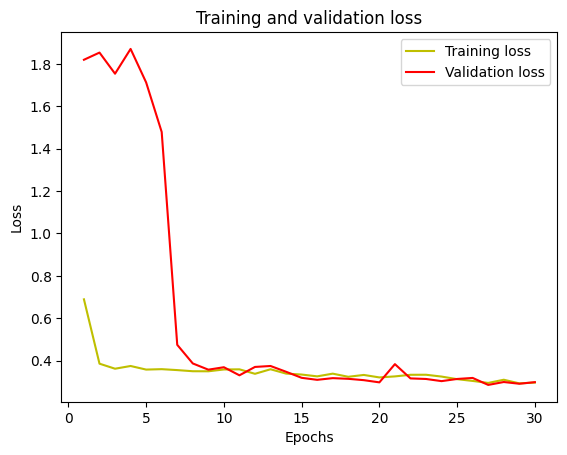

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

loss =model_history.history['loss']
val_loss =model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

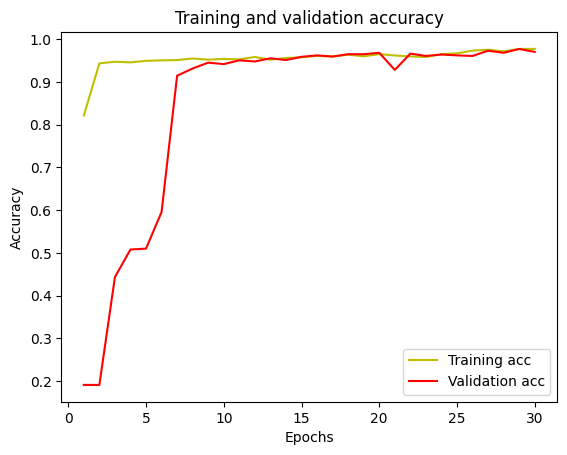

In [15]:
acc =model_history.history['accuracy']
val_acc =model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Validation macro F1: 0.9784
Validation micro F1: 0.9769
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       243
           1       1.00      1.00      1.00       203
           2       1.00      1.00      1.00       207
           3       0.88      0.99      0.93       246
           4       1.00      0.89      0.94       281
           5       1.00      1.00      1.00       291

    accuracy                           0.98      1471
   macro avg       0.98      0.98      0.98      1471
weighted avg       0.98      0.98      0.98      1471



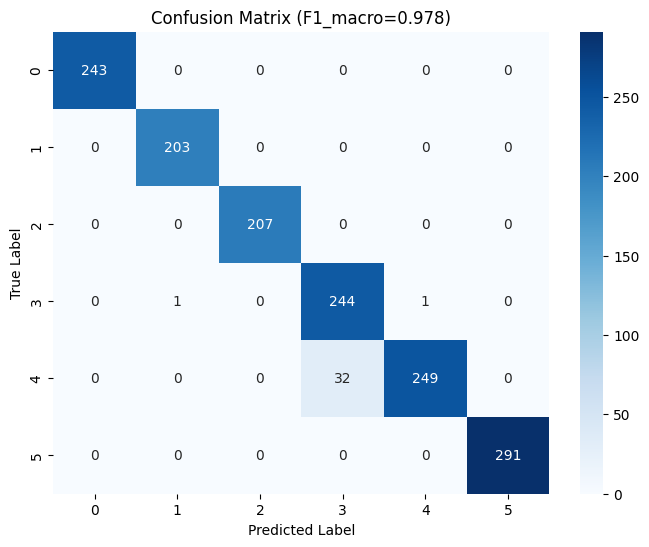

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import numpy as np

# 예측
y_val_prob = resnet_cbam_model.predict(X_val_scaled, batch_size=256)
y_val_pred = y_val_prob.argmax(axis=1)
y_val_true = y_val_one_hot.argmax(axis=1)

# 혼동행렬
cm = confusion_matrix(y_val_true, y_val_pred)
f1_macro = f1_score(y_val_true, y_val_pred, average='macro')
f1_micro = f1_score(y_val_true, y_val_pred, average='micro')

# 결과 출력
print(f"Validation macro F1: {f1_macro:.4f}")
print(f"Validation micro F1: {f1_micro:.4f}")
print(classification_report(y_val_true, y_val_pred))

# -----------------------------
# 🔥 히트맵 시각화
# -----------------------------
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=np.unique(y_val_true),
            yticklabels=np.unique(y_val_true))
plt.title(f'Confusion Matrix (F1_macro={f1_macro:.3f})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
